In [10]:
import math

def is_odd(num: int):
    return num % 2 != 0

def get_kernel(elements: int):
    kernel = []
    for k in range(elements):
        i = k - math.floor(elements / 2)
        if is_odd(k):
            x = (-4 / (math.pi ** 2)) / (i ** 2)
            kernel.append(x)
        else:
            kernel.append(0)
    kernel[math.floor(elements / 2)] = 1
    return kernel

kernel = get_kernel(21)

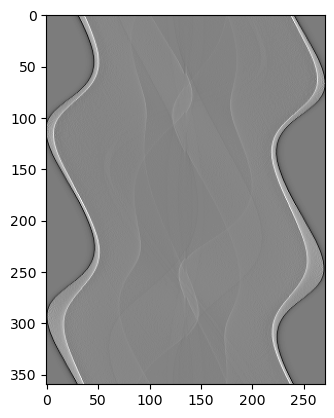

In [13]:
from matplotlib import image
from matplotlib import pyplot as plt
from skimage.draw import line_nd
import numpy as np

raw = np.average(np.array(image.imread('images/Shepp_logan.jpg')), axis=2)
size = np.max(raw.shape)

data = np.zeros([size, size]) + raw

def circle_point(angle: float):
    x = math.sin(np.radians(angle))
    y = math.cos(np.radians(angle))
    return np.array([x, y])

def end_points(start_angle: float, rank: int, resolution_angle: float):
    opposite_angle = start_angle + 180
    points = np.array([circle_point(opposite_angle)])
    for i in range(rank):
        left = circle_point(opposite_angle + resolution_angle * i)
        right = circle_point(opposite_angle - resolution_angle * i)
        points = np.array([left, *points ,right])
    return points

def ray(data, start, stop):
    line = line_nd(start, stop)
    ray = data[line]
    return np.average(ray)

step_angle = 1
emitters = 270

angles = np.linspace(0, 360, num=math.floor(360 / step_angle), endpoint=False)
rank = math.floor(emitters / 2)

sinogram = []
for angle in angles:
    slice = np.array([])
    start = circle_point(angle) * (size/2) + (size/2 - 1)
    for end_point in end_points(angle, rank, 1.0):
        stop = end_point * (size/2) + (size/2 - 1)
        z = ray(data, start, stop)
        slice = np.append(slice, z)
    slice = np.convolve(slice, kernel, mode='same')
    sinogram = [*sinogram, slice]

plt.imshow(sinogram, cmap="gray")

In [14]:
from ipywidgets import interact, widgets

inverse = [np.zeros(data.shape)]

for (j, angle) in enumerate(angles):
    current = np.copy(inverse[-1])
    start = circle_point(angle) * (size/2) + (size/2 - 1)
    for (i, end_point) in enumerate(end_points(angle, rank, 1.0)):
        stop = end_point * (size/2) + (size/2 - 1)
        out = line_nd(start, stop)
        current[out] += sinogram[j][i]
    inverse = [*inverse, current]


def show(x: int):
    plt.imshow(inverse[x], cmap='gray')

interact(show, x=widgets.IntSlider(min=0, max=len(angles), step=1, value=len(angles)))

interactive(children=(IntSlider(value=360, description='x', max=360), Output()), _dom_classes=('widget-interac…

<function __main__.show(x: int)>